---

# Covariate Set Combinations & Tests

By: Tomás Urdiales

-> Notebook for experimenting with different covariate sets.

##### Libraries

In [ ]:
# Change notebook CWD to the project's root, so python can read from src:
import os
os.chdir("..")

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_absolute_error, mean_squared_error

from src import utils
from src.cross_validation import backtesting_CV
from src.join_qh_min_data import join_qh_min_data

##### Parameters

In [9]:
CWD = utils.get_root_dir()

# To not use darts plotting style:
plt.style.use('default')

DPI = 150 # (pixel density for figures)
ELIA_ORANGE = (250/256, 115/256, 1/256) # RGB

##### Load data

In [10]:
qh = utils.load_qh_historical_data().loc["2021":"2022"]
minute = utils.load_min_historical_data().loc["2021":"2022"]
ems = utils.load_ems_historical_data().loc["2021":"2022"]
xb = utils.load_xb_historical_data().loc["2021":"2022"]
temp = utils.load_temp_historical_data().loc["2021":"2022"]

# Additional features:
minute["rolling_15"] = minute["system_imbalance"].rolling(window=15, center=False).mean()
minute["rolling_60"] = minute["system_imbalance"].rolling(window=60, center=False).mean()
# Add in XB data:
qh = qh.assign(xb_day_ahead = xb["xb_day_ahead"])
qh = qh.assign(xb_intraday = xb["xb_intraday"])
qh = qh.assign(xb_grand_total = xb["xb_grand_total"])
qh = qh.assign(xb_physical_accounting_net_import_mw = xb["xb_physical_accounting_net_import_mw"])
# Add in temperature data:
qh = qh.assign(temperature = temp["temperature"])
# Create temperature gradient with respect to one hour ahead:
qh = qh.assign(temperature_diff = -temp["temperature"].diff(-4))

In [11]:
def check(a,b):
    print(f"{(1-a/111.98)*100 :.1f}% | {(1-b/148.97)*100 :.1f}% | {a/145.55 :.3f}")

In [12]:
# Model to be used for all tests (it's faster than LinearRegression)
from sklearn.linear_model import Ridge

model_ridge = Ridge(
    alpha=0.5,
    tol=1e-4,
    max_iter=1000,
    solver="auto",
)

---

## Missing entries with legacy covariate set

In [6]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
    "si_mw": {
        "lags": [-1, -2, -3, -4]},
    "load_id_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -3]},
    "net_regulation_volume": {
        "lags": [-2, -3]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)

In [7]:
set(df.loc[df.isnull().any(axis=1), df.columns[df.isnull().any(axis=0)]].index.date)

{datetime.date(2021, 1, 1),
 datetime.date(2021, 1, 26),
 datetime.date(2021, 5, 27),
 datetime.date(2021, 7, 22),
 datetime.date(2021, 9, 17),
 datetime.date(2021, 10, 31),
 datetime.date(2022, 3, 22),
 datetime.date(2022, 4, 26),
 datetime.date(2022, 9, 22),
 datetime.date(2022, 10, 30),
 datetime.date(2022, 12, 31)}

---

## Legacy model benchmark

In [13]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
    "si_mw": {
        "lags": [-1, -2, -3, -4]},
    "load_id_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -3]},
    "net_regulation_volume": {
        "lags": [-2, -3]},
}

# Prepare training dataframe:d
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 8, test_size=15 * 4 * 24 * 4, gap=0)

# Cross-validation:
results_linear = backtesting_CV(model=LinearRegression(),
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False
                                )

check(111.98, 148.97)

MODEL: LinearRegression
Time configuration: 91 splits, 4 testing days, 8 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:13<00:00,  6.91it/s]



Train set average error:
MAE: 110.69MW | RMSE: 147.18MW
Test set average error:
MAE: 111.98MW | RMSE: 148.97MW | MASE: 0.7470 | P90 Error: 236.77MW | Max Error: 1151.7 (2022-09-06 21:15:00+02:00)
Time elapsed: 13.27s | Time per split: ~0.15s

0.0% | 0.0% | 0.769


---

## Rolling mean features

In [26]:
qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
    "si_mw": {
        "lags": [-1, -2, -3, -4]},
    "load_id_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -3]},
    "net_regulation_volume": {
        "lags": [-2, -3]},
    "rolling_15": {
        "lags": [-2]},
    "rolling_60": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    # ems_data=ems,
    # ems_parameters=ems_parameters,
)

TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 8, test_size=15 * 4 * 24 * 4, gap=0)

# Cross-validation:
results_linear = backtesting_CV(model=model_ridge,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 8 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:07<00:00, 11.65it/s]


Train set average error:
MAE: 110.65MW | RMSE: 147.14MW
Test set average error:
MAE: 111.99MW | RMSE: 149.00MW | MASE: 0.7472 | P90 Error: 236.76MW | Max Error: 1155.8 (2022-09-06 21:15:00+02:00)
Time elapsed: 7.87s | Time per split: ~0.09s



---

## Simplest AR set

This is the simplest possible model that gets us legacy model level results! This can be considered the baseline to beat.

*It's obtained using Lasso on the previous covariate set.

In [ ]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -5, -95, -671]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2]},
}


# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 8, test_size=15 * 4 * 24 * 4, gap=0)

results_linear = backtesting_CV(model=model_ridge,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False)

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 8 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:04<00:00, 20.14it/s]



Train set average error:
MAE: 110.30MW | RMSE: 146.58MW
Test set average error:
MAE: 111.14MW | RMSE: 147.83MW | MASE: 0.7414 | P90 Error: 235.31MW | Max Error: 1154.5 (2022-09-06 21:17:00+02:00)
Time elapsed: 4.59s | Time per split: ~0.05s



---

## Extended AR set

*Extended using Lasso AFS

In [7]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, 
        -95, -94, -93, -96,
        -191, -190, -189, -192,
        -287, -286, -285, -288,
        -383, -382, -381, -384,
        -479, -478, -477, -480,
        -575, -574, -573, -576,
        -671, -670, -669, -672,
        -17, -21, -23]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -45, -181, -18, -33, -64, -44, -43, -63]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 20, test_size=15 * 4 * 24 * 4, gap=0)

results_linear = backtesting_CV(model=LinearRegression(),
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False)
check(107.34, 143.25)

MODEL: LinearRegression
Time configuration: 91 splits, 4 testing days, 20 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:42<00:00,  2.15it/s]


Train set average error:
MAE: 104.66MW | RMSE: 139.60MW
Test set average error:
MAE: 107.34MW | RMSE: 143.25MW | MASE: 0.7165 | P90 Error: 227.81MW | Max Error: 1137.8 (2022-09-06 21:17:00+02:00)
Time elapsed: 42.48s | Time per split: ~0.47s

4.1% | 3.8% | 0.737


---

## AFS Recommended Set

In [19]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, 
        -95, -94, -93, -96,
        -191, -190, -189, -192,
        -287, -286, -285, -288,
        -383, -382, -381, -384,
        -479, -478, -477, -480,
        -575, -574, -573, -576,
        -671, -670, -669, -672,
        -17, -21, -23]},

    "total_load_last_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},

    "nrv_rt": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "load_rt_mw": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "wind_rt_mw": {
        "lags": [-1, -2, -3, -4]},

    # "total_load_forecast_last_p10_mw": {
    #     "lags": [-4]},
    # "total_load_forecast_last_p90_mw": {
    #     "lags": [-4]},

    # "ppos":{
    #     "lags": [-1, -2, -3, -4]},
    # "pneg":{
    #     "lags": [-1, -2, -3, -4]},
    # "guv_mw":{
    #     "lags": [-1, -2, -3, -4]},
    # "gdv_mw":{
    #     "lags": [-1, -2, -3, -4]}
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -3, -4, -45, -181, -18, -33, -64, -44, -43, -63]},

    "net_regulation_volume": {
        "lags": [-2, -3, -4]},
    "rolling_15": {
        "lags": [-2]},
    "rolling_60": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    # ems_data=ems,
    # ems_parameters=ems_parameters,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 8, test_size=15 * 4 * 24 * 4, gap=0)

In [20]:
# Cross-validation:
results_linear = backtesting_CV(model=model_ridge,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 8 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:34<00:00,  2.60it/s]


Train set average error:
MAE: 105.31MW | RMSE: 140.50MW
Test set average error:
MAE: 107.28MW | RMSE: 143.47MW | MASE: 0.7156 | P90 Error: 227.44MW | Max Error: 1189.9 (2022-10-05 10:00:00+02:00)
Time elapsed: 35.06s | Time per split: ~0.39s



---

## XB DA-ID data

In [13]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, 
        -95, -94, -93, -96,
        -191, -190, -189, -192,
        -287, -286, -285, -288,
        -383, -382, -381, -384,
        -479, -478, -477, -480,
        -575, -574, -573, -576,
        -671, -670, -669, -672,
        -17, -21, -23]},

    "xb_grand_total": {
        "lags": [4, 1, 0, -4]},

    "total_load_last_mw": {
        "lags": [3, -3]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
    "load_rt_mw": {
        "lags": [-3]},
    "wind_rt_mw": {
        "lags": [-1, -3]},

    "temperature_diff": {
    "lags": [4, 0]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -181, -18, -33, -64, -63]},

    "net_regulation_volume": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [14]:
# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 30, test_size=15* 4 * 24 * 4, gap=0)

# Cross-validation:
results_linear = backtesting_CV(model=model_ridge,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)
check(102.5, 135.92)

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 30 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:32<00:00,  2.78it/s]



Train set average error:
MAE: 98.72MW | RMSE: 130.83MW
Test set average error:
MAE: 102.50MW | RMSE: 135.92MW | MASE: 0.6841 | P90 Error: 216.38MW | Max Error: 1138.0 (2022-10-05 10:00:00+02:00)
Time elapsed: 32.96s | Time per split: ~0.36s

8.5% | 8.8%


---

## Sparse set

In [16]:
FEATURES = ['xb_grand_total_from_qh_plus_1', 'xb_grand_total_current_qh',
       'system_imbalance_from_minute_minus_2',
       'system_imbalance_cum15_from_qh_minus_3',
       'total_load_last_mw_from_qh_plus_3',
       'total_load_last_mw_from_qh_minus_3',
       'xb_grand_total_from_qh_plus_4',
       'net_regulation_volume_from_minute_minus_2',
       'system_imbalance_cum15_from_qh_minus_95',
       'system_imbalance_cum15_from_qh_minus_191',
       'system_imbalance_cum15_from_qh_minus_671',
       'system_imbalance_cum15_from_qh_minus_287',
       'system_imbalance_cum15_from_qh_minus_383',
       'xb_grand_total_from_qh_minus_4',
       'system_imbalance_cum15_from_qh_minus_96',
       'system_imbalance_cum15_from_qh_minus_672',
       'nrv_rt_from_qh_minus_1',
       'temperature_diff_from_qh_plus_4',
       'system_imbalance_cum15_from_qh_minus_192',
       'system_imbalance_cum15_from_qh_minus_384',
       'nrv_rt_from_qh_minus_3',
       'system_imbalance_cum15_from_qh_minus_1',
       'system_imbalance_cum15_from_qh_minus_288',
       'temperature_diff_current_qh',
       'system_imbalance_cum15_from_qh_minus_381']

In [17]:
# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 8, test_size=15* 4 * 24 * 4, gap=0)

# Cross-validation:
results_linear = backtesting_CV(model=model_ridge,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)

MODEL: Ridge
Time configuration: 91 splits, 60 testing days, 120 training weeks. Total predicted time: 5460 days.



100%|██████████| 91/91 [00:07<00:00, 12.30it/s]


Train set average error:
MAE: 103.09MW | RMSE: 136.34MW
Test set average error:
MAE: 104.36MW | RMSE: 138.12MW | MASE: 6.6715 | P90 Error: 219.59MW | Max Error: 1171.2 (2022-10-05 10:00:00+02:00)
Time elapsed: 7.46s | Time per split: ~0.08s



---

## EMS Features

Test out on the legacy set:

In [ ]:
MINUTE = "all"

ems_parameters = {
    "elia_sum_prod_mw_cm-value": {
        "lags": [-2, -3, -4]},
}

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
    "si_mw": {
        "lags": [-1, -2, -3, -4]},
    "load_id_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -3]},
    "net_regulation_volume": {
        "lags": [-2, -3]},
}


# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    ems_data=ems,
    ems_parameters=ems_parameters
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 8, test_size=15 * 4 * 24 * 4, gap=0)

# Cross-validation:
results_linear = backtesting_CV(model=model_ridge,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False)

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 8 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:06<00:00, 13.53it/s]


Train set average error:
MAE: 110.41MW | RMSE: 146.72MW
Test set average error:
MAE: 111.79MW | RMSE: 148.59MW | MASE: 0.7457 | P90 Error: 236.08MW | Max Error: 1150.7 (2022-09-06 21:16:00+02:00)
Time elapsed: 6.79s | Time per split: ~0.07s



## Differences in EMS features

In [ ]:
MINUTE = "all"

ems_parameters = {
    "elia_sum_prod_mw_cm-value-diff": {
        "lags": [-2, -3, -4]},
}

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
    "si_mw": {
        "lags": [-1, -2, -3, -4]},
    "load_id_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -3]},
    "net_regulation_volume": {
        "lags": [-2, -3]},
}


# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    ems_data=ems,
    ems_parameters=ems_parameters
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 8, test_size=15 * 4 * 24 * 4, gap=0)

# Cross-validation:
results_linear = backtesting_CV(model=model_ridge,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False)

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 8 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:07<00:00, 11.72it/s]


Train set average error:
MAE: 110.42MW | RMSE: 146.72MW
Test set average error:
MAE: 111.71MW | RMSE: 148.52MW | MASE: 0.7452 | P90 Error: 236.10MW | Max Error: 1149.4 (2022-09-06 21:15:00+02:00)
Time elapsed: 7.82s | Time per split: ~0.09s



---

## Dummy variable encoding

In [18]:
# Let's encode hour of day with dummy variables:
df = df.assign(hour_of_day=df.index.hour.astype("category"))
df = pd.get_dummies(df,
    columns=["hour_of_day"],
    drop_first=True, prefix="hour", prefix_sep="_")

In [19]:
# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=4 * 24 * 7 * 8, test_size=4 * 24 * 4, gap=0)

# Cross-validation:
results_linear = backtesting_CV(model=LinearRegression(),
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)

MODEL: LinearRegression
Time configuration: 91 splits, 4 testing days, 8 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:31<00:00,  2.87it/s]


Train set average error:
MAE: 106.56MW | RMSE: 142.01MW
Test set average error:
MAE: 108.55MW | RMSE: 144.94MW | MASE: 0.7242 | P90 Error: 229.25MW | Max Error: 1069.7 (2022-09-06 21:18:00+02:00)
Time elapsed: 31.70s | Time per split: ~0.35s



In [20]:
bins = pd.IntervalIndex.from_tuples([(0, 14), (15,29), (30,44), (45,59)])

# Let's encode hour of day with dummy variables:
df = df.assign(qh=pd.cut(df.index.minute, bins).astype("category"))
df = pd.get_dummies(df,
    columns=["qh"],
    drop_first=True, prefix="qh", prefix_sep="_")

In [21]:
# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=4 * 24 * 7 * 8, test_size=4 * 24 * 4, gap=0)

# Cross-validation:
results_linear = backtesting_CV(model=LinearRegression(),
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)

MODEL: LinearRegression
Time configuration: 91 splits, 4 testing days, 8 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:30<00:00,  2.97it/s]


Train set average error:
MAE: 106.56MW | RMSE: 142.01MW
Test set average error:
MAE: 108.55MW | RMSE: 144.94MW | MASE: 0.7242 | P90 Error: 229.25MW | Max Error: 1069.7 (2022-09-06 21:18:00+02:00)
Time elapsed: 30.64s | Time per split: ~0.34s



---

## Fitting on residuals

In [22]:
MINUTE = 3
qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, -4*24]},
    "si_mw": {
        "lags": [-1, -2, -3, -4, -5, -4*24]},
}
minute_parameters = {
    "system_imbalance": {
        "lags": [0, -1, -2, -3]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    # ems_data=ems,
    # ems_parameters=ems_parameters,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4 + 4, max_train_size=4 * 24 * 7 * 8, test_size=4 * 24 * 4, gap=0)

# Cross-validation:
results_linear = backtesting_CV(model=LinearRegression(),
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False)


MODEL: LinearRegression
Time configuration: 95 splits, 4 testing days, 8 training weeks. Total predicted time: 380 days.



100%|██████████| 95/95 [00:03<00:00, 24.21it/s]


Train set average error:
MAE: 110.86MW | RMSE: 147.17MW
Test set average error:
MAE: 111.72MW | RMSE: 148.50MW | MASE: 0.7526 | P90 Error: 236.59MW | Max Error: 1111.5 (2022-09-06 21:18:00+02:00)
Time elapsed: 3.94s | Time per split: ~0.04s



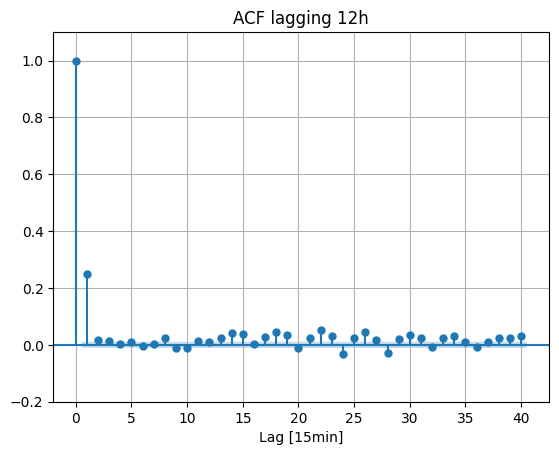

/opt/homebrew/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


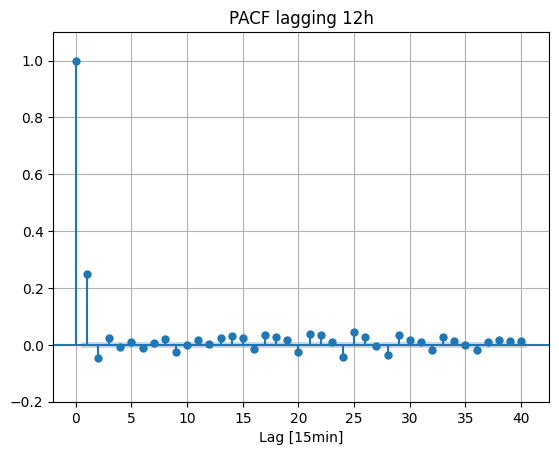

In [23]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(results_linear[0]["y_test"]-results_linear[0]["y_pred"], alpha=.05, lags=4*10,
                         ax=ax, title="ACF lagging 12h")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [15min]')
plt.grid()
plt.show()

fig, ax = plt.subplots()
sm.graphics.tsa.plot_pacf(results_linear[0]["y_test"]-results_linear[0]["y_pred"], alpha=.05, lags=4*10,
                         ax=ax, title="PACF lagging 12h")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [15min]')
plt.grid()
plt.show()

In [24]:
res = pd.DataFrame({"res": results_linear[0]["y_test"] - results_linear[0]["y_pred"]})
res = res.assign(lag1=res.res.shift(1))

TARGET = "res"
FEATURES = [feature for feature in res.columns if feature != TARGET]

res = res.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=4 * 24 * 7 * 2, test_size=4 * 24 * 4, gap=0)

# Cross-validation:
results_res = backtesting_CV(model=LinearRegression(),
                             data=res,
                             time_splits=tscv,
                             features=FEATURES,
                             target=TARGET,
                             progress_bar=False,
                             verbose=False,
                             print_error_metrics=False)

from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = results_linear[0]["y_pred"].loc["2022-01-01 13:08:00+01:00":"2022-12-31 23:38:00+01:00"] + \
    results_res[0]["y_pred"].loc["2022-01-01 13:08:00+01:00":"2022-12-31 23:38:00+01:00"]

y_test = results_linear[0]["y_test"].loc["2022-01-01 13:08:00+01:00":"2022-12-31 23:38:00+01:00"]

total_mae = mean_absolute_error(y_test, y_pred)
total_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"\nTotal MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

MODEL: LinearRegression
Time configuration: 91 splits, 4 testing days, 2 training weeks. Total predicted time: 364 days.


Total MAE: 109.72MW | Total RMSE: 145.27MW


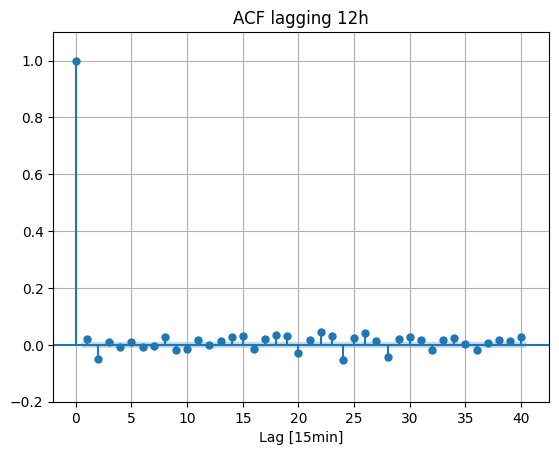

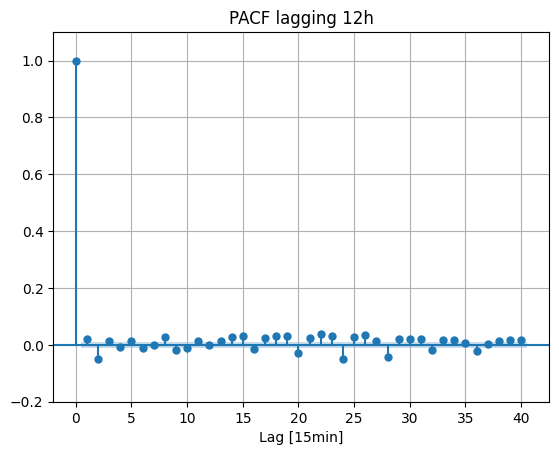

In [25]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(y_test - y_pred, alpha=.05, lags=4*10,
                         ax=ax, title="ACF lagging 12h")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [15min]')
plt.grid()
plt.show()

fig, ax = plt.subplots()
sm.graphics.tsa.plot_pacf(y_test - y_pred, alpha=.05, lags=4*10, method="ywm",
                         ax=ax, title="PACF lagging 12h")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [15min]')
plt.grid()
plt.show()